# The dataset is Churn Dataset. It's downloaded from DQLab https://storage.googleapis.com/dqlab-dataset/dqlab_telco_final.csv

## Import the dataset

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/dqlab_telco_final.csv')
df.head()

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,202006,45759018157,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,202006,45315483266,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,202006,45236961615,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,202006,45929827382,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,202006,45305082233,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No


In [8]:
df.shape

(6950, 13)

## Cleaning the dataset

### Finding for outliers in dataset using boxplot

{'boxes': [<matplotlib.lines.Line2D at 0x7f8597d41510>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8597d4acd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8597d4af50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8598906e10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8597d474d0>,
  <matplotlib.lines.Line2D at 0x7f8597d47c50>]}

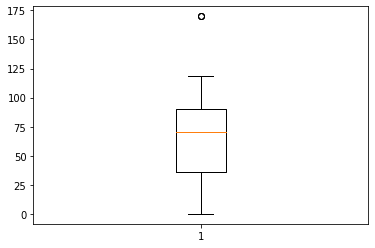

In [9]:
import matplotlib.pyplot as plt

plt.boxplot(df["MonthlyCharges"])

Outliers found in MonthlyCharges column

### Removing the ouliers

In [10]:
# Q1, Q3, dan IQR
Q1 = df['MonthlyCharges'].quantile(0.25)
Q3 = df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1

# Removing outliers
df = df[~((df['MonthlyCharges'] < (Q1 - 1.5 * IQR)) | (df['MonthlyCharges'] > (Q3 + 1.5 * IQR)))]


print('Shape: ', df.shape)

Shape akhir:  (6947, 13)


### Drop unnecessary columns

In [11]:
df.drop(columns=["UpdatedAt", "customerID"], inplace=True)
df.head()

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No


## Simple data analysis

### Distribution of values in Churn column

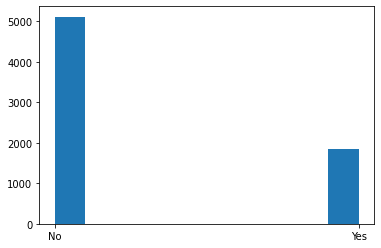

In [12]:
plt.hist(df["Churn"]);

### Plotting the analysis for numerical columns

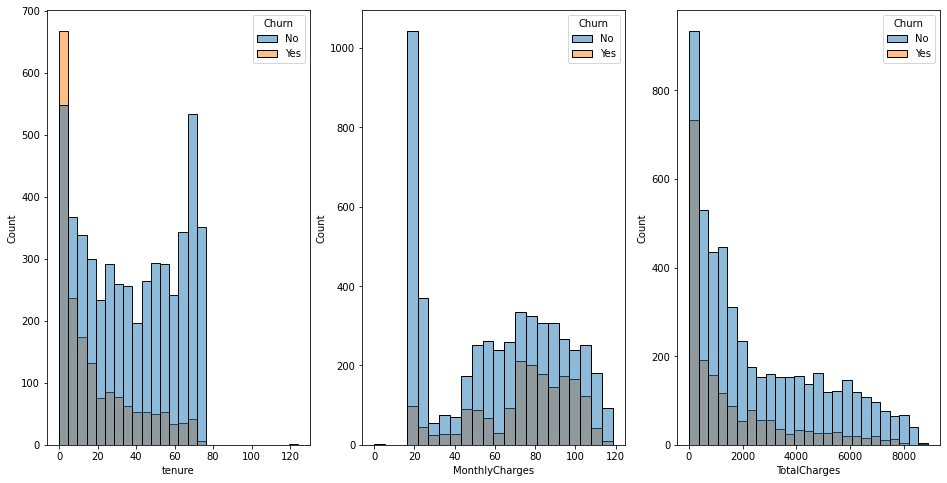

In [14]:
import seaborn as sns
numeric_col = ["tenure","MonthlyCharges","TotalCharges"]

plt.figure(figsize=(16, 8))

plt.subplot(131)
sns.histplot(data=df, x='tenure', hue="Churn")

plt.subplot(132)
sns.histplot(data=df, x="MonthlyCharges", hue="Churn")

plt.subplot(133)
sns.histplot(data=df, x="TotalCharges", hue="Churn")

In [15]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'tenure', 'PhoneService',
       'StreamingTV', 'InternetService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn'],
      dtype='object')

### Plotting analysis for categorical columns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

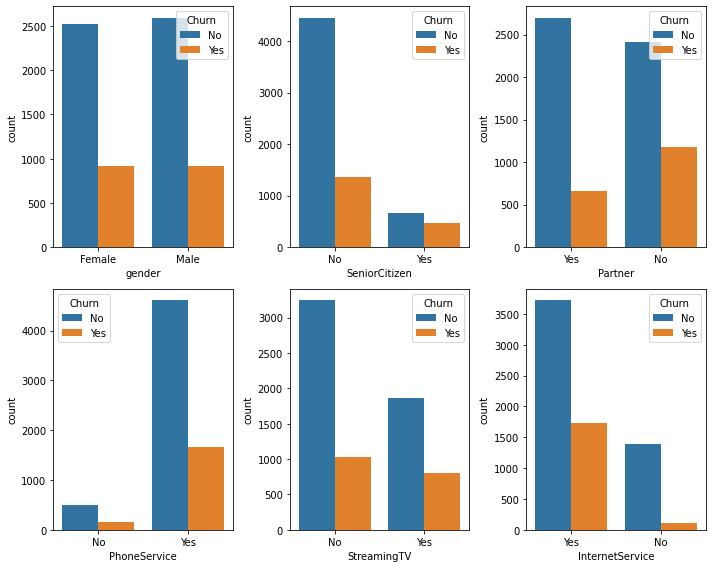

In [16]:
var_columns = ["gender", "SeniorCitizen", "Partner", 'PhoneService', 'StreamingTV', 'InternetService']

fig, axes =plt.subplots(2, 3, figsize=(10,8))
for var_columns, ax in zip(var_columns, axes.flatten()):
  sns.countplot(var_columns, data=df, hue="Churn", ax=ax)
  plt.tight_layout();

## Into Machine Learning Steps

### Splitting dataset

In [19]:
from sklearn.model_selection import train_test_split
from jcopml.pipeline import num_pipe, cat_pipe
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [20]:
# Dataset Spliting
X = df.drop(columns="Churn")
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4862, 10), (2085, 10), (4862,), (2085,))

### Preprocessing data
Advanced cleaning dataset steps are done again here to prevent data leakage

---


Steps:


1.   Scaling
2.   Imputing the missing values
3.   Encoding




In [21]:
#Preprocessor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax'), ['tenure', 'MonthlyCharges', 'TotalCharges']),
    ('categoric', cat_pipe(encoder='onehot'), ["gender", "SeniorCitizen", "Partner", "PhoneService", "StreamingTV", "InternetService", "PaperlessBilling"]),
])


## Training the model

Algorithm to use is Logistic Regression as it works very well in dataset with label 0 and 1

In [22]:
#Training
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [23]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
    
    ])
    
model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'algo__C': 10.0, 'algo__fit_intercept': True}
0.7945290004113533 0.7920601010908778 0.7971223021582734


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    4.5s finished


The score for test is 79

## Model Evaluation

In [24]:
y_train_pred = model.predict(X_train)

In [27]:
from jcopml.plot import plot_confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

          No       0.83      0.91      0.87      3577
         Yes       0.65      0.48      0.55      1285

    accuracy                           0.79      4862
   macro avg       0.74      0.69      0.71      4862
weighted avg       0.78      0.79      0.78      4862



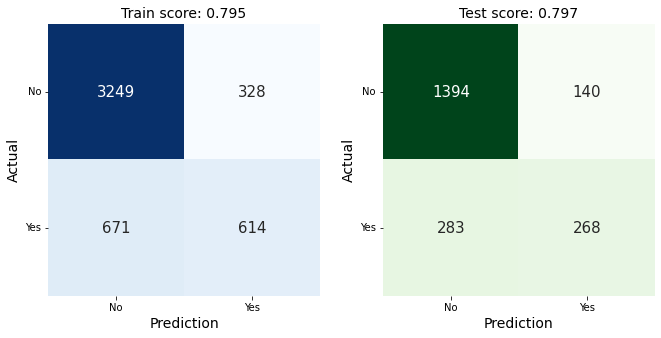

In [28]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)